# Intra TAD ratios over all the contacts

In [1]:
import pandas as pd
import cooler
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pybedtools

In [2]:
downsample_dir = Path(
    "/tscc/projects/ps-epigen/users/biy022/scmethylhic/human_hippocampus/"
    "snm3c/Combined/hic/downsampled/"
)
tad_dir = Path("/tscc/projects/ps-renlab2/sel041/scmethylhic/human_hippocampus/concat/hic/celltype/")

In [3]:
figure_dir = Path(
    "/tscc/projects/ps-epigen/users/biy022/scmethylhic/"
    "human_hippocampus/snm3c/Combined/hic/figures/"
)

In [4]:
# Meta data
meta_file = (
    "/tscc/projects/ps-renlab2/sel041/scmethylhic/human_hippocampus/"
    "concat/human_aging_final_metadata.csv.gz"
)
meta_df = pd.read_csv(meta_file, header=0, index_col=1)
meta_df.drop(meta_df.columns[0], axis=1, inplace=True)

In [5]:
def summarize_intra_tad_prop_per_cell(subclass):
    curr_df = meta_df.loc[meta_df.final_celltype == subclass, :]
    print("{}: {}".format(subclass, curr_df.shape[0]))

    curr_TAD_file = str(tad_dir / ("human_aging_" + subclass + "_psueobulk_domain_filtered.bed"))
    curr_TAD_df = pd.read_csv(curr_TAD_file, header=0, sep=",")
    curr_TAD_bed = pybedtools.BedTool.from_dataframe(curr_TAD_df)

    intra_TAD_ratios = pd.DataFrame(
        np.zeros((curr_df.shape[0], 4)),
        columns=["subclass", "age", "intraTAD", "total"]
    )
    intra_TAD_ratios["subclass"] = subclass
    intra_TAD_ratios["age"] = "20-40"

    hic_prefix = Path("/tscc/projects/ps-epigen/users/biy022/scmethylhic/human_hippocampus/snm3c/")
    counter = 0
    for row in curr_df.itertuples():
        if counter % 100 == 0:
            print("\tWorking on {}th row...".format(counter))
        curr_file_name = hic_prefix / (row.sample + "_deep") / "hic" / "rmbkl" / (row.Index + ".contact.rmbkl.tsv.gz")
        curr_hic_df = pd.read_csv(curr_file_name, header=None, sep="\t")
        curr_hic_df_cis = curr_hic_df.loc[curr_hic_df[1] == curr_hic_df[5], :]
        curr_hic_bed = pybedtools.BedTool.from_dataframe(curr_hic_df_cis[[1,2,6]])
        tad_count = curr_hic_bed.intersect(curr_TAD_bed, wa=True, u=True, f=1.0).to_dataframe().shape[0]
        total_count = curr_hic_df.shape[0]
        intra_TAD_ratios.iloc[counter, :] = [subclass, row.group, tad_count, total_count]
        counter += 1
        ## pybedtools.cleanup(remove_all=True)

    intra_TAD_ratios["ratio"] = intra_TAD_ratios["intraTAD"] / intra_TAD_ratios["total"]
    print("Finished {}, {}".format(subclass, counter))
    return intra_TAD_ratios

In [6]:
subclass_order = [
    "Astro", "Oligo", "OPC", "Micro", "Endo_VLMC",
    "SUB", "CA", "DG",
    "PVALB", "SST", "NR2F2-LAMP5", "VIP"
]

In [7]:
pybedtools.set_tempdir("/tscc/projects/ps-epigen/users/biy022/tmp/")

In [8]:
intra_TAD_ratios_list = []
for subclass in subclass_order:
    intra_TAD_ratios = summarize_intra_tad_prop_per_cell(subclass)
    intra_TAD_ratios_list.append(intra_TAD_ratios)

Astro: 2497
	Working on 0th row...
	Working on 100th row...
	Working on 200th row...
	Working on 300th row...
	Working on 400th row...
	Working on 500th row...
	Working on 600th row...
	Working on 700th row...
	Working on 800th row...
	Working on 900th row...
	Working on 1000th row...
	Working on 1100th row...
	Working on 1200th row...
	Working on 1300th row...
	Working on 1400th row...
	Working on 1500th row...
	Working on 1600th row...
	Working on 1700th row...
	Working on 1800th row...
	Working on 1900th row...
	Working on 2000th row...
	Working on 2100th row...
	Working on 2200th row...
	Working on 2300th row...
	Working on 2400th row...
Finished Astro, 2497
Oligo: 13188
	Working on 0th row...
	Working on 100th row...
	Working on 200th row...
	Working on 300th row...
	Working on 400th row...
	Working on 500th row...
	Working on 600th row...
	Working on 700th row...
	Working on 800th row...
	Working on 900th row...
	Working on 1000th row...
	Working on 1100th row...
	Working on 1200

In [9]:
final_df = pd.concat(intra_TAD_ratios_list, axis=0, ignore_index=True)

In [10]:
final_df

,subclass,age,intraTAD,total,ratio
0,Astro,60-80,13172.0,67251.0,0.195863
1,Astro,60-80,10129.0,46724.0,0.216784
2,Astro,60-80,5409.0,52505.0,0.103019
3,Astro,60-80,17371.0,86089.0,0.201780
4,Astro,60-80,18676.0,89150.0,0.209490
...,...,...,...,...,...
22235,VIP,40-60,87148.0,308354.0,0.282623
22236,VIP,40-60,12685.0,39249.0,0.323193
22237,VIP,40-60,98186.0,345022.0,0.284579
22238,VIP,40-60,10882.0,31317.0,0.347479


<Axes: xlabel='subclass', ylabel='ratio'>

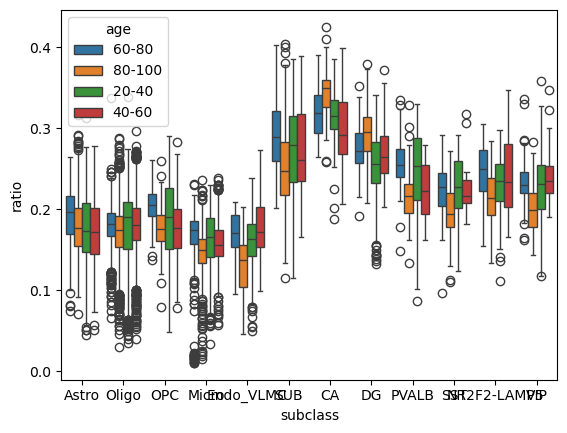

In [11]:
sns.boxplot(final_df, x="subclass", y="ratio", hue="age")

In [12]:
final_df.to_csv(
    figure_dir / "intra_TAD_ratios_all.csv",
    header=True,
    index=False,
    sep=","
)

## Plot

In [4]:
subclass_order = [
    "Astro", "Oligo", "OPC", "Micro", "Endo_VLMC",
    "SUB", "CA", "DG",
    "PVALB", "SST", "NR2F2-LAMP5", "VIP"
]

In [5]:
age_colors = {
    "20-40": "#1B9E77",
    "40-60": "#CCCD66",
    "60-80": "#7570B3",
    "80-100": "#E7298A"
}

In [6]:
final_df = pd.read_csv(
    figure_dir / "intra_TAD_ratios_all.csv",
    header=0, sep=","
)

In [7]:
final_df

,subclass,age,intraTAD,total,ratio
0,Astro,60-80,13172.0,67251.0,0.195863
1,Astro,60-80,10129.0,46724.0,0.216784
2,Astro,60-80,5409.0,52505.0,0.103019
3,Astro,60-80,17371.0,86089.0,0.201780
4,Astro,60-80,18676.0,89150.0,0.209490
...,...,...,...,...,...
22235,VIP,40-60,87148.0,308354.0,0.282623
22236,VIP,40-60,12685.0,39249.0,0.323193
22237,VIP,40-60,98186.0,345022.0,0.284579
22238,VIP,40-60,10882.0,31317.0,0.347479


In [8]:
final_df["subclass"] = pd.Categorical(
    final_df["subclass"], categories=subclass_order)
final_df["age"] = pd.Categorical(
    final_df["age"], categories=["20-40", "40-60", "60-80", "80-100"])

In [9]:
import itertools

In [10]:
n_celltypes = final_df["subclass"].unique().size
n_groups = 4
test_results = pd.DataFrame({
    "celltype": itertools.chain.from_iterable([x] * n_groups for x in subclass_order),
    "group": ["20-40", "40-60", "60-80", "80-100"] * n_celltypes,
    "pvalue": [0.0] * (n_celltypes * n_groups),
    "stars": [""] * (n_celltypes * n_groups),
})

In [11]:
test_results["celltype"] = pd.Categorical(
    test_results["celltype"], categories=subclass_order, ordered=True)
test_results["group"] = pd.Categorical(
    test_results["group"], categories=["20-40", "40-60", "60-80", "80-100"], ordered=True)

In [12]:
from scipy.stats import mannwhitneyu

In [13]:
for celltype, subdf in final_df.groupby("subclass"):
    x = subdf.loc[subdf["age"] == "20-40", "ratio"]
    for group in ["40-60", "60-80", "80-100"]:
        y = subdf.loc[subdf["age"] == group, "ratio"]
        stat, p_value = mannwhitneyu(x, y)

        sel_index = (test_results["celltype"] == celltype) & (test_results["group"] == group)
        test_results.loc[sel_index, "pvalue"] = p_value

        stars = ""
        if p_value < 0.01:
            stars = "*"
        if p_value < 0.001:
            stars = "**"
        test_results.loc[sel_index, "stars"] = stars

/tmp/ipykernel_1221253/15411649.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for celltype, subdf in final_df.groupby("subclass"):


In [14]:
test_results = test_results.sort_values(by=["group", "celltype"])

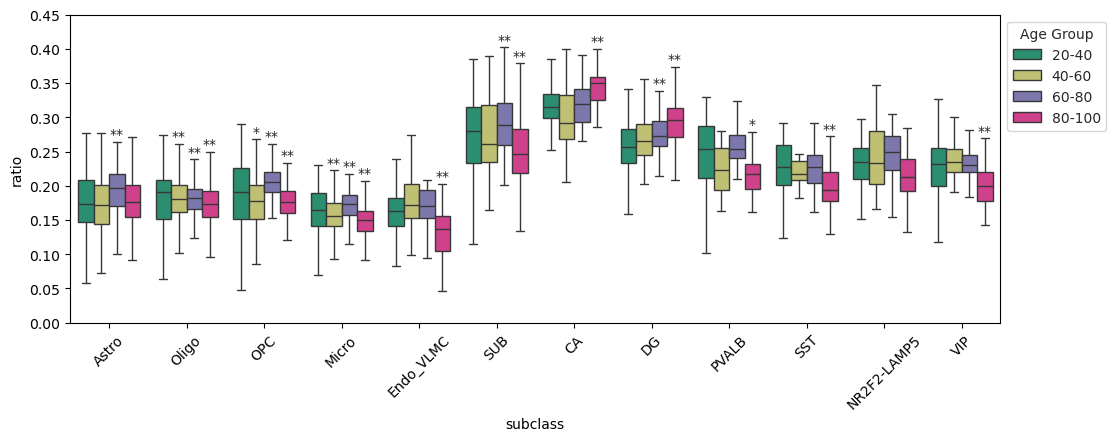

In [15]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(12)
fig.set_figheight(4)
sns.set_style("white")
sns.boxplot(
    final_df, x="subclass", y="ratio", hue="age",
    ax=ax, palette=age_colors, showfliers=False
)
plt.legend(title='Age Group', loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45);
x = [j + i for j in [-0.3, -0.1, 0.1, 0.3] for i in np.arange(0, 12)]
y = np.array([ax.get_lines()[i].get_ydata()[1] for i in np.arange(1, 240, 5)]) + 0.005
ax.set_ylim([0.0, 0.45])
for k, (i, j) in enumerate(zip(x, y)):
    plt.text(i, j, test_results.iloc[k, 3], ha="center", fontsize=10)
fig.savefig(
    str(figure_dir / (f"All_age_intra_TAD_ratio" + ".pdf")),
    dpi=300,
    format="pdf",
    bbox_inches="tight"
)

## Median and Mean of contact ratios

In [4]:
final_df = pd.read_csv(
    figure_dir / "intra_TAD_ratios_all.csv",
    header=0, sep=","
)

In [9]:
tmp = final_df.groupby(["subclass", "age"])["ratio"].agg(["mean", "median"]).reset_index()

In [10]:
tmp.to_csv(
    figure_dir / "intra_TAD_ratios_median_mean.csv",
    header=True,
    index=False,
    sep=","
)